In [1]:
%%capture
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

In [2]:
%%capture
!pip install -e ../../tools/nomad/

In [1]:
import os
import sys
from datetime import datetime

import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import spearmanr

# to be able to import from tools dir
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.scDEED as scd
import tools.clustering_opt as co
import tools.util_plot as nmd_plot

import fi_nomad as nmd
from fi_nomad.types import kernelInputTypes
from fi_nomad.types import KernelStrategy
from fi_nomad.types import InitializationStrategy

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import kendalltau
import importlib
import logging

In [2]:
data_all = sc.read_h5ad("../../data/MOBA_scRNAseq/MOBA_intermediate_results/S3_filtered_with_counts.h5ad")
data_all

AnnData object with n_obs × n_vars = 1544 × 5553
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

### Get clustering info from Poisson Hurdle

In [3]:
import json

In [6]:
with open("../../ph/cluster_solution_s3_0.5samples_1genes_k5/S3_abs_05samples_1genes_k5.json") as f:
    phclust_abs = json.load(f)

In [7]:
with open("../../ph/cluster_solution_s3_0.5samples_1genes_k5/S3_rel_05samples_1genes_k5.json") as f:
    phclust_rel = json.load(f)

In [8]:
def adjust_indices_r2python(phclust_result):
    phclust_result["cluster"] = [str(int(x) - 1) for x in phclust_result["cluster"]]
    phclust_result["rows2keep"] = [int(x) - 1 for x in phclust_result["rows2keep"]]
    phclust_result["cols2keep"] = [int(x) - 1 for x in phclust_result["cols2keep"]]
    return phclust_result

In [9]:
phclust_abs = adjust_indices_r2python(phclust_abs)
phclust_rel = adjust_indices_r2python(phclust_rel)

Filter dataframe to have the same rows as the one phclust was run on.

In [10]:
len(phclust_abs["cluster"])

785

In [11]:
dat = data_all[:,phclust_abs["cols2keep"]]
dat = dat[phclust_abs["rows2keep"],:]
dat 

View of AnnData object with n_obs × n_vars = 785 × 5549
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'vst_counts'

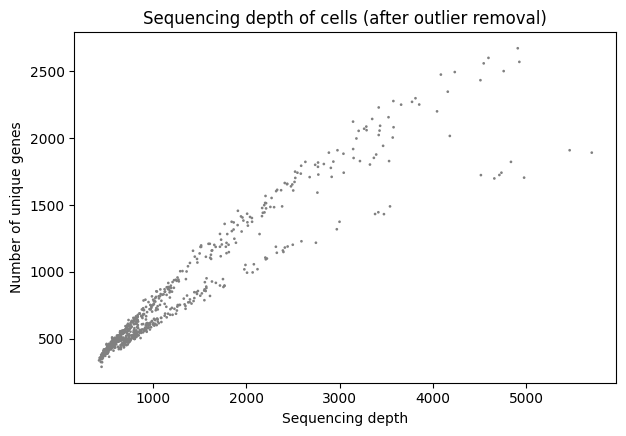

In [12]:
sc.pl.scatter(dat, x='total_counts', y='n_genes_by_counts', show=False, size=15)
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

## Variance stabilization

In [13]:
dat.X = dat.layers["counts"].copy().toarray()

In [14]:
dat.X

ArrayView([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
           [ 0.,  0.,  1., ...,  1.,  7.,  0.],
           [ 1.,  0.,  1., ...,  0.,  6.,  0.],
           ...,
           [ 3.,  5.,  1., ...,  3., 18.,  1.],
           [ 1.,  0.,  0., ...,  1.,  1.,  0.],
           [ 0.,  1.,  1., ...,  1.,  6.,  0.]])

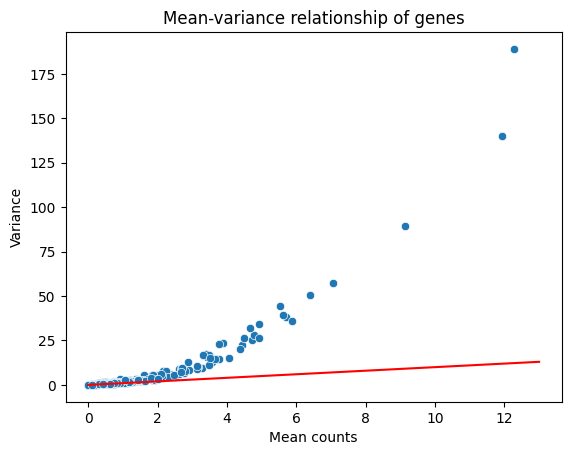

In [15]:
dat.var["var_counts"] = np.asarray(np.var(dat.X, axis=0)).squeeze()
dat.var["mean_counts"] = np.asarray(np.mean(dat.X, axis=0)).squeeze()
sns.scatterplot(data=dat.var, x="mean_counts", y="var_counts")
plt.plot([0, np.ceil(np.max(dat.var["mean_counts"]))], [0, np.ceil(np.max(dat.var["mean_counts"]))], color="red")
plt.title("Mean-variance relationship of genes")
plt.xlabel("Mean counts")
plt.ylabel("Variance")
plt.show()

## Estimate negative binomial parameters for each gene

In [16]:
nb.estimate_overdisp_nb(dat, layer="counts", flavor="BFGS")
dat.var["nb_overdisp_cutoff_bfgs"] = dat.var["nb_overdisp_cutoff"]
dat.var["nb_overdisp_bfgs"] = dat.var["nb_overdisp"]


Fitting feature 100/5549
Fitting feature 200/5549
Fitting feature 300/5549
Fitting feature 400/5549
Fitting feature 500/5549
Fitting feature 600/5549
Fitting feature 700/5549
Fitting feature 800/5549
Fitting feature 900/5549
Fitting feature 1000/5549
Fitting feature 1100/5549
Fitting feature 1200/5549
Fitting feature 1300/5549
Fitting feature 1400/5549
Fitting feature 1500/5549
Fitting feature 1600/5549
Fitting feature 1700/5549
Fitting feature 1800/5549
Fitting feature 1900/5549
Fitting feature 2000/5549
Fitting feature 2100/5549
Fitting feature 2200/5549
Fitting feature 2300/5549
Fitting feature 2400/5549
Fitting feature 2500/5549
Fitting feature 2600/5549
Fitting feature 2700/5549
Fitting feature 2800/5549
Fitting feature 2900/5549
Fitting feature 3000/5549
Fitting feature 3100/5549
Fitting feature 3200/5549
Fitting feature 3300/5549
Fitting feature 3400/5549
Fitting feature 3500/5549
Fitting feature 3600/5549
Fitting feature 3700/5549
Fitting feature 3800/5549
Fitting feature 3900/

In [17]:
importlib.reload(nb)
nb.estimate_overdisp_nb(dat, layer="counts")

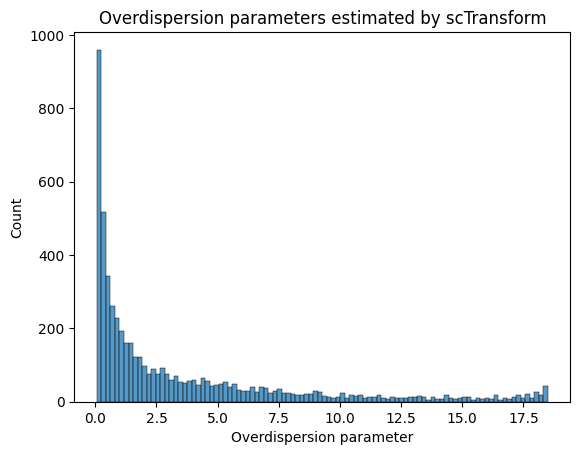

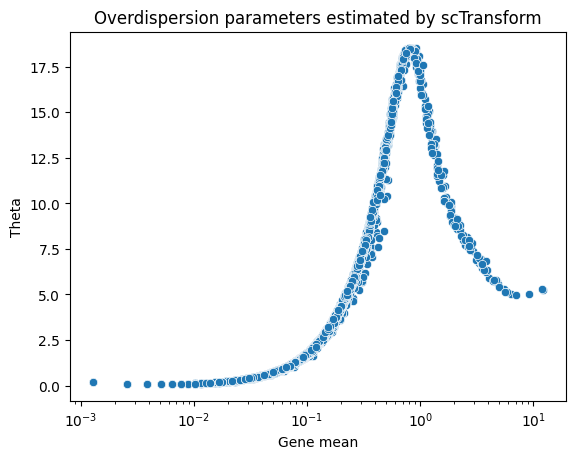

In [18]:
sns.histplot(data=dat.var, x="nb_overdisp_cutoff", bins=100)
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Overdispersion parameter")
plt.show()

g = sns.scatterplot(data=dat.var, y="nb_overdisp_cutoff", x="mean_counts")
g.set(xscale="log")
plt.title("Overdispersion parameters estimated by scTransform")
plt.xlabel("Gene mean")
plt.ylabel("Theta")
plt.show()

In [19]:
dat.X = dat.layers["counts"].copy()

## Normalization, VST, scaling and PCA

In [20]:
sc.pp.normalize_total(dat, target_sum=None, layer=None)
dat.X = sps.csr_matrix(np.log(dat.X.toarray() + np.array(dat.var["nb_overdisp_cutoff"] / 4)))
dat.layers["vst_counts"] = dat.X.copy()
sc.pp.scale(dat, max_value=10, zero_center=True)
# data_gene.X[np.isnan(data_gene.X)] = 0
sc.tl.pca(dat, svd_solver='arpack')

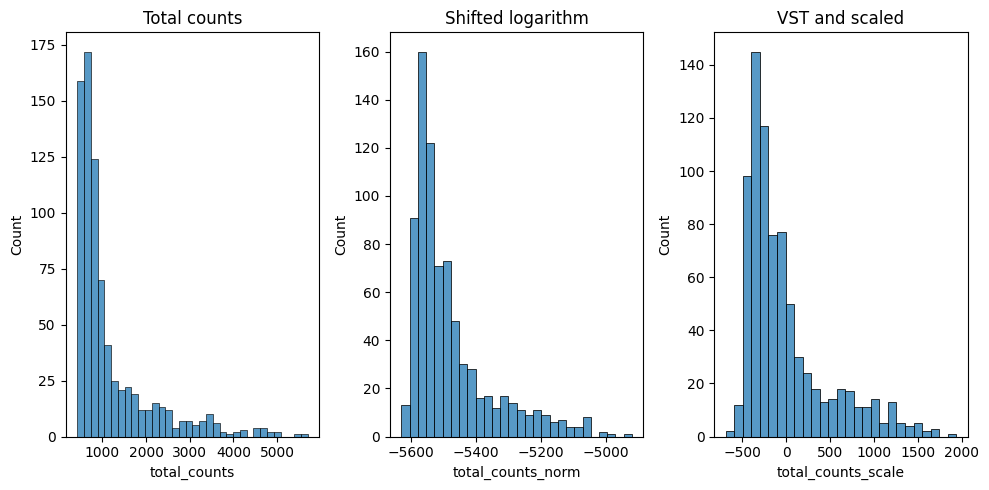

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
p1 = sns.histplot(dat.obs, x="total_counts", kde=False, ax=axes[0], multiple="stack")
axes[0].set_title("Total counts")
dat.obs["total_counts_norm"] = dat.layers["vst_counts"].sum(1)
p2 = sns.histplot(dat.obs, x="total_counts_norm", kde=False, ax=axes[1], multiple="stack")
axes[1].set_title("Shifted logarithm")
dat.obs["total_counts_scale"] = dat.X.sum(1)
p2 = sns.histplot(dat.obs, x="total_counts_scale", kde=False, ax=axes[2], multiple="stack")
axes[2].set_title("VST and scaled")
plt.tight_layout()
plt.show()

## Count-splitting into train and test data

In [20]:
data_train, data_test = cs.countsplit_adata(dat, data_dist="NB", beta_key="nb_overdisp_cutoff", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 785 × 5344
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm', 'total_counts_scale', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'var_counts', 'nb_mean', 'nb_overdisp', 'nb_overdisp_cutoff', 'nb_overdisp_cutoff_bfgs', 'nb_overdisp_bfgs', 'mean', 'std', 'is_scd_outlier'
    layers: 'counts'


In [21]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp_cutoff"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp_cutoff"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

### Principal component selection

In [22]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

Optimal number of PCs:3


In [25]:
k_opt = 3

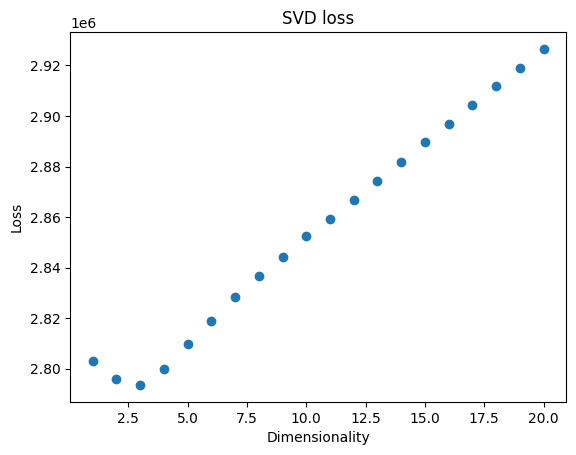

In [23]:
plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()

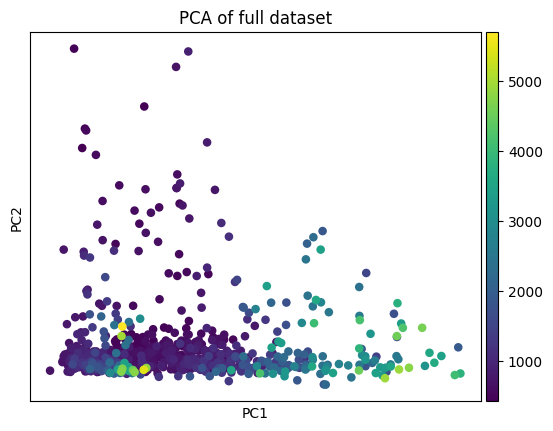

In [24]:
sc.pl.pca(dat, color="total_counts", cmap="viridis", title="PCA of full dataset")
plt.show()

## Selection of optimal number of neighbors and optimal UMAP scale via scDEED

In [25]:
dat.layers["vst_counts"]

<785x5549 sparse matrix of type '<class 'numpy.float64'>'
	with 4355965 stored elements in Compressed Sparse Row format>

In [26]:
importlib.reload(scd)

n_neighbors = [10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 150, 200, 250]
min_dists = [0.05, 0.1, 0.3, 0.5, 0.7]

scdeed_result, rel_scores, null_rel_scores, reliabilities, n_neighbors_opt, min_dist_opt = scd.scdeed_parameter_selection(dat, n_neighbors, min_dists, n_pcs=k_opt, rng_seed=5678, embedding_method="UMAP", similarity_percent=0.5, save_path="S3_filtered_scdeed", layer="counts")

calculating (10, 0.05) - run 1/85
calculating (10, 0.1) - run 2/85
calculating (10, 0.3) - run 3/85
calculating (10, 0.5) - run 4/85
calculating (10, 0.7) - run 5/85
calculating (15, 0.05) - run 6/85
calculating (15, 0.1) - run 7/85
calculating (15, 0.3) - run 8/85
calculating (15, 0.5) - run 9/85
calculating (15, 0.7) - run 10/85
calculating (20, 0.05) - run 11/85
calculating (20, 0.1) - run 12/85
calculating (20, 0.3) - run 13/85
calculating (20, 0.5) - run 14/85
calculating (20, 0.7) - run 15/85
calculating (25, 0.05) - run 16/85
calculating (25, 0.1) - run 17/85
calculating (25, 0.3) - run 18/85
calculating (25, 0.5) - run 19/85
calculating (25, 0.7) - run 20/85
calculating (30, 0.05) - run 21/85
calculating (30, 0.1) - run 22/85
calculating (30, 0.3) - run 23/85
calculating (30, 0.5) - run 24/85
calculating (30, 0.7) - run 25/85
calculating (35, 0.05) - run 26/85
calculating (35, 0.1) - run 27/85
calculating (35, 0.3) - run 28/85
calculating (35, 0.5) - run 29/85
calculating (35, 

Optimal number of neighbors: 25
Optimal min_dist: 0.05


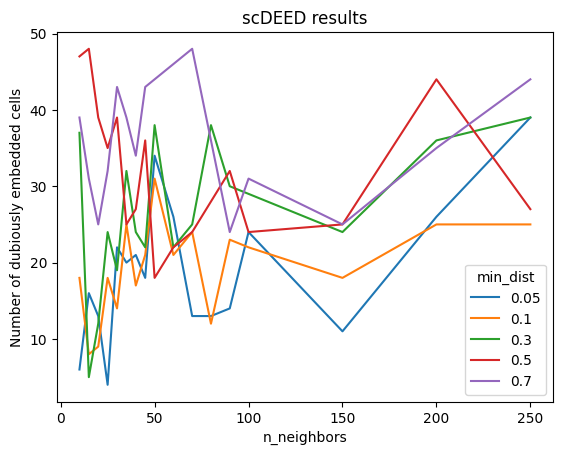

In [27]:
print(f"Optimal number of neighbors: {n_neighbors_opt}")
print(f"Optimal min_dist: {min_dist_opt}")

sns.lineplot(data=scdeed_result, x="n_neighbors", y="num_dubious", hue="min_dist", palette="tab10")
plt.title("scDEED results")
plt.ylabel("Number of dubiously embedded cells")
plt.show()

In [22]:
n_neighbors_opt = 25
min_dist_opt = 0.05
k_opt = 3

In [26]:
sc.pp.neighbors(dat, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(dat, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


KeyError: 'Could not find key embedding_reliability in .var_names or .obs.columns.'

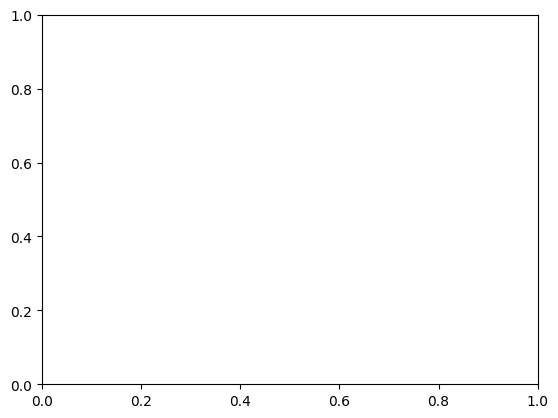

In [27]:
sc.pl.umap(dat, color="embedding_reliability", alpha=1)
plt.show()

sc.pl.umap(dat, color="total_counts", alpha=1, cmap="viridis")
plt.show()

## Clustering

### Train/test-split for clustering

In [30]:
sc.pp.neighbors(data_train, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_train, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)

sc.pp.neighbors(data_test, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_test, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1, random_state=1234)


theta_opt, mirror_opt, umap_2_opt, ssd = ut.find_opt_umap_rotation(data_train.obsm["X_umap"].copy(), data_test.obsm["X_umap"].copy())
data_test.obsm["X_umap_rot"] = umap_2_opt

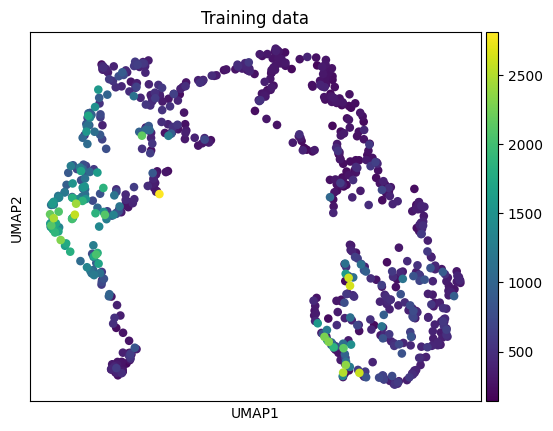

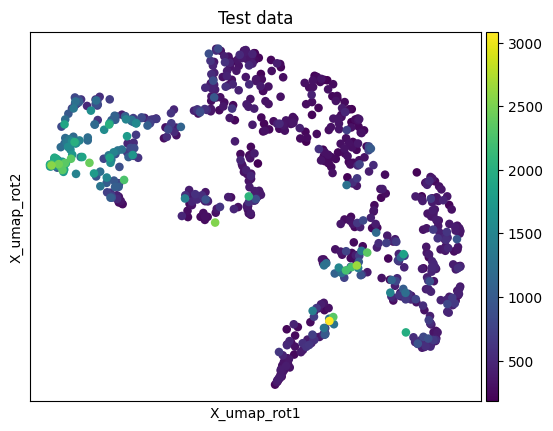

In [31]:
sc.pl.umap(data_train, color="total_counts", cmap="viridis", title="Training data")
plt.show()

sc.pl.embedding(data_test, basis="X_umap_rot", color="total_counts", cmap="viridis", title="Test data")
plt.show()

### Apply clustering with array of resolutions

In [32]:
importlib.reload(co)
res_min = 0.01
res_max = 0.5
res_step = 0.02
resolutions = np.round(np.arange(res_min, res_max, res_step), 2)

co.cluster_train_test(data_train, data_test, resolutions, alg="leiden")

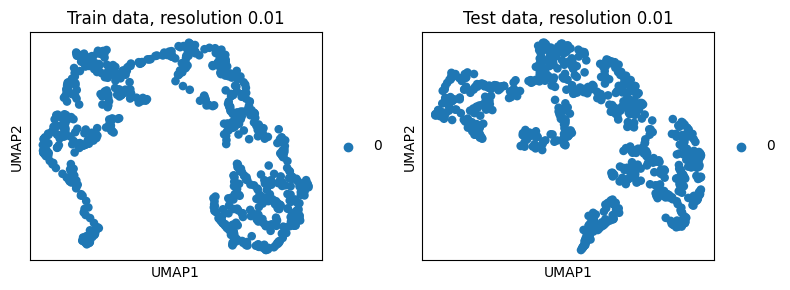

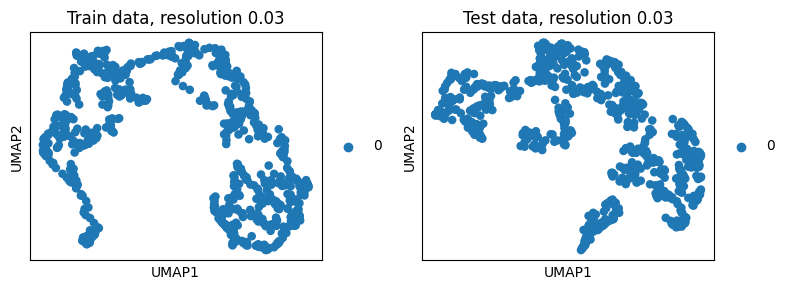

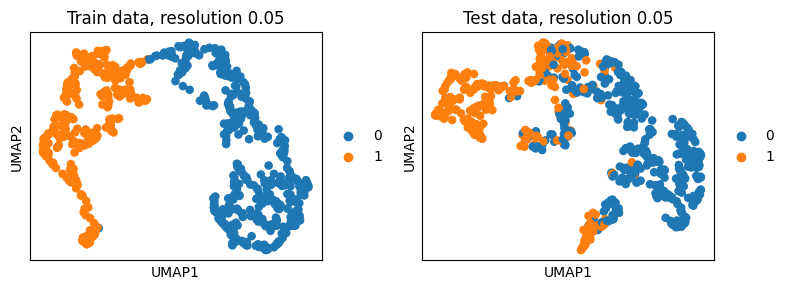

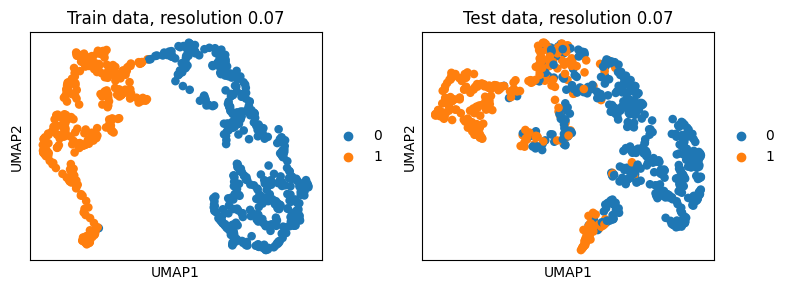

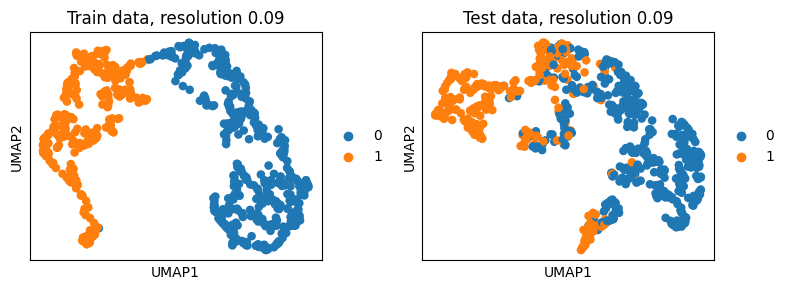

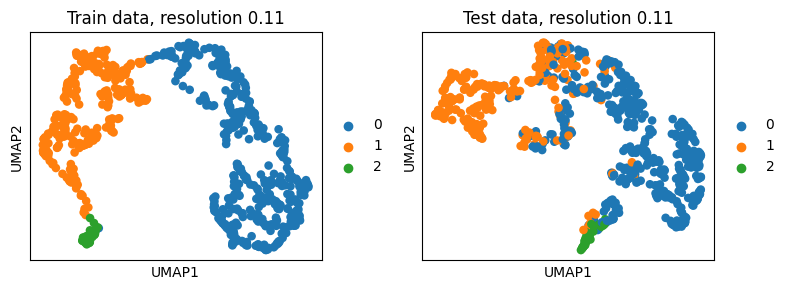

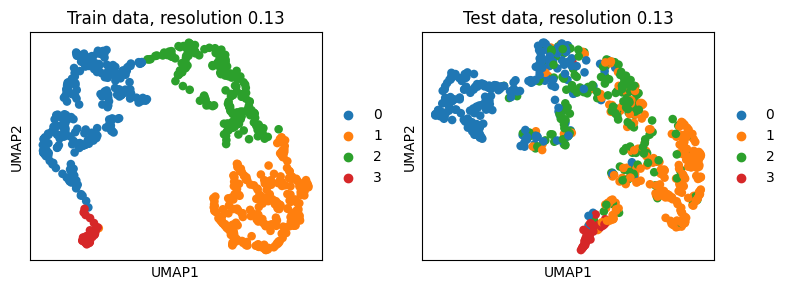

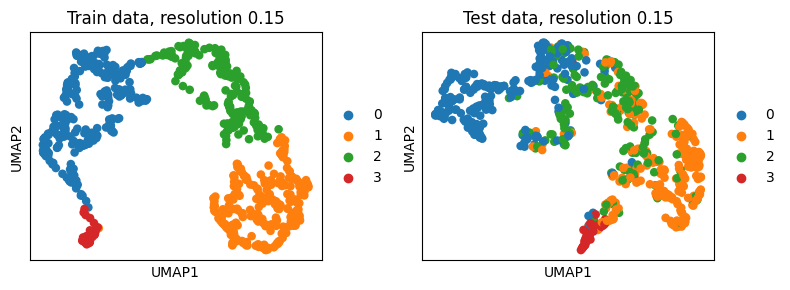

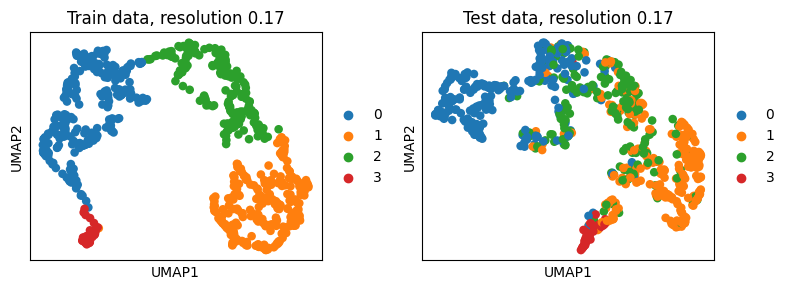

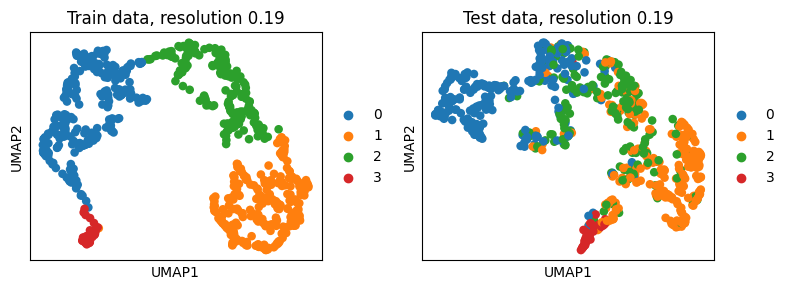

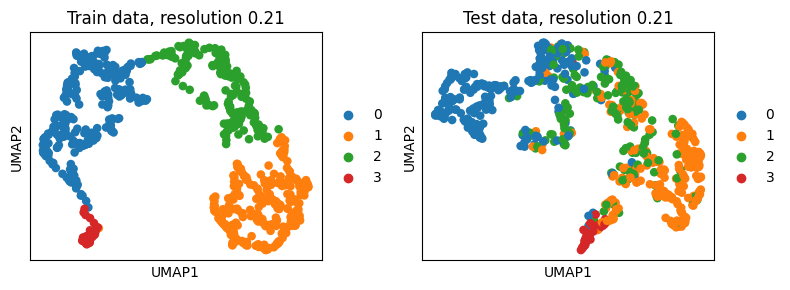

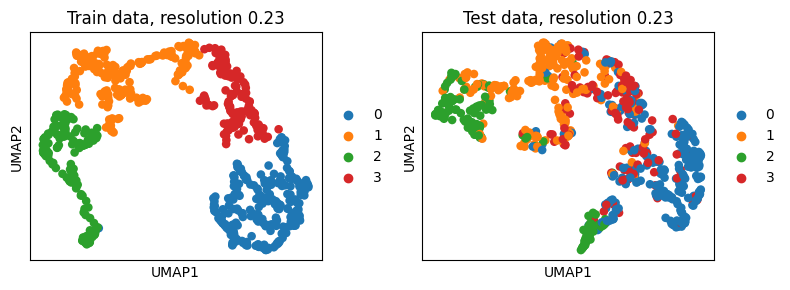

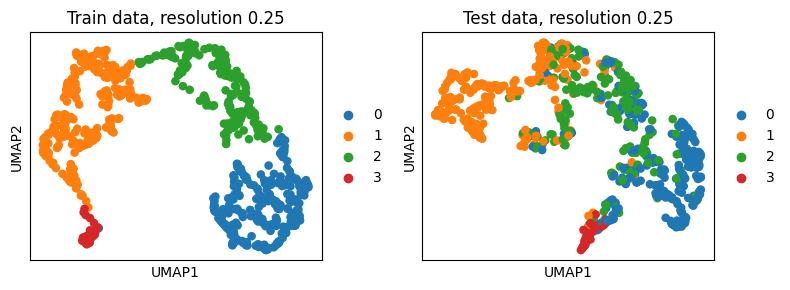

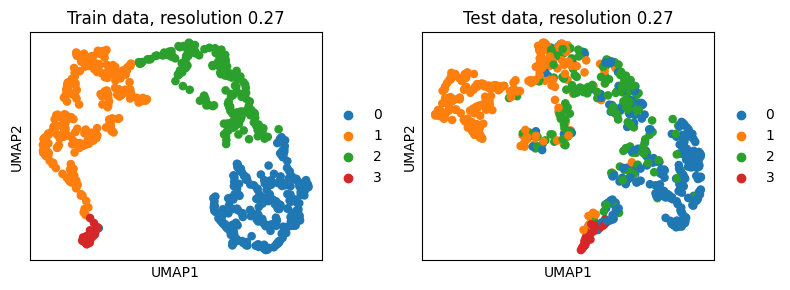

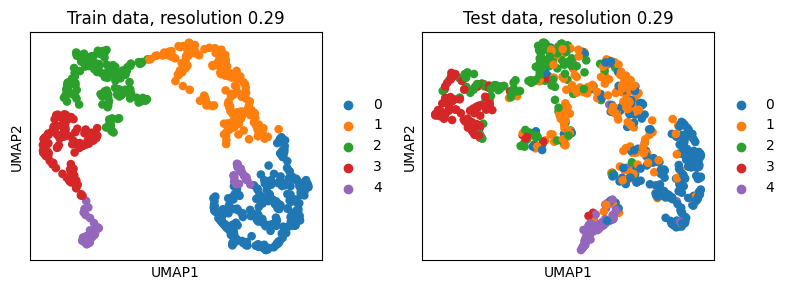

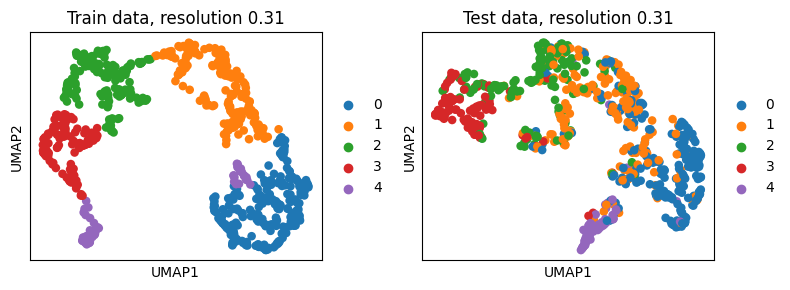

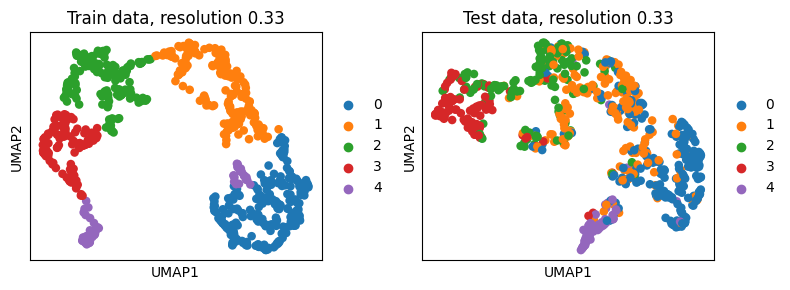

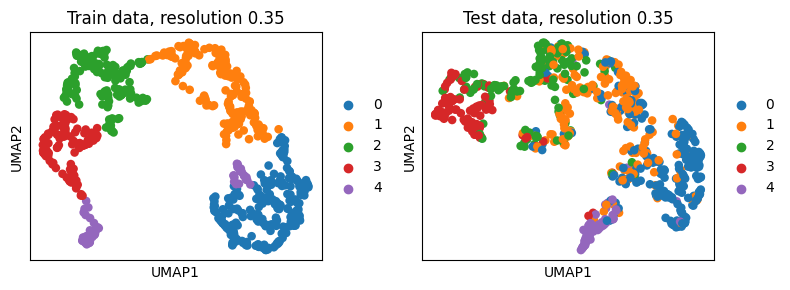

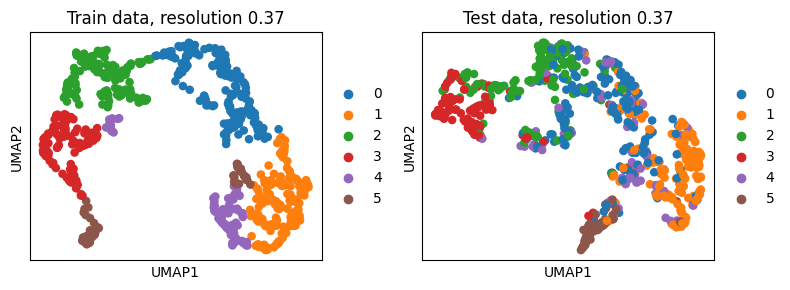

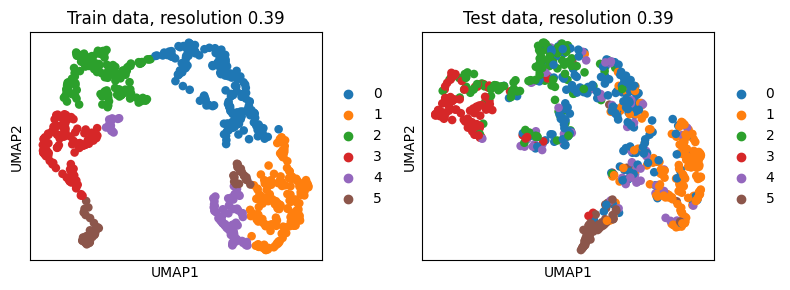

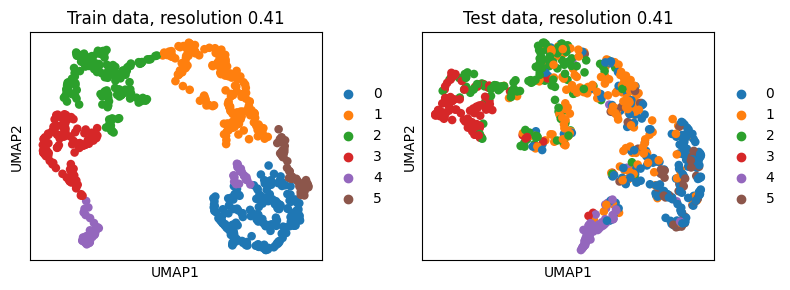

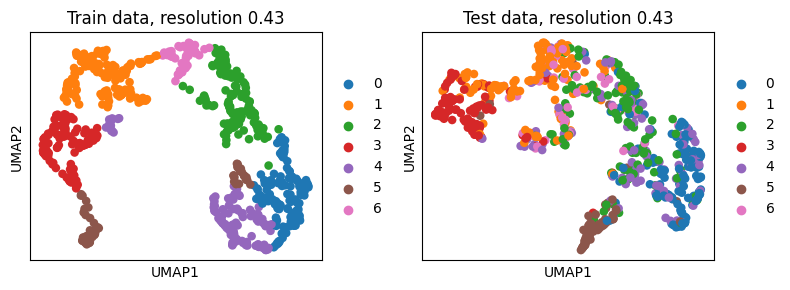

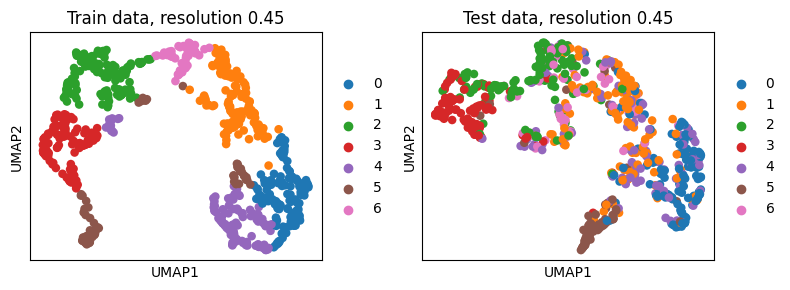

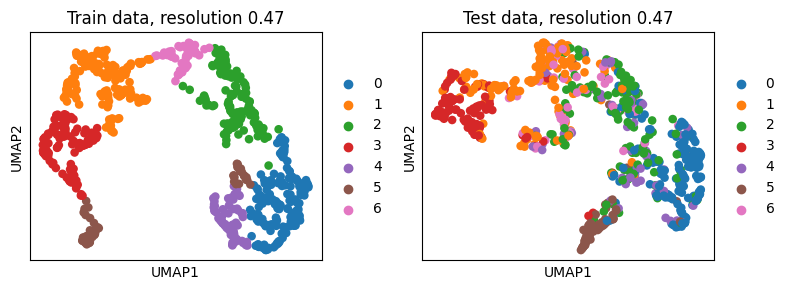

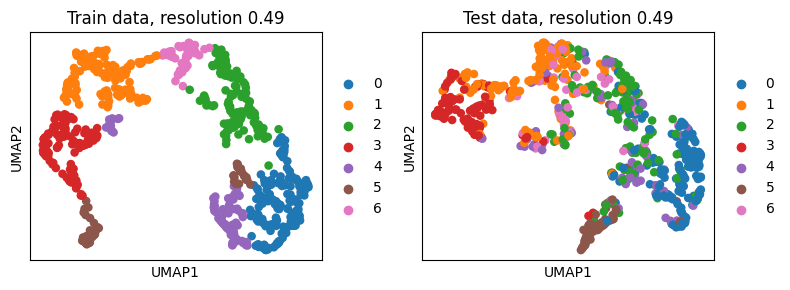

In [33]:
for resolution in resolutions:
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    sc.pl.umap(data_train, color=f"leiden_res{resolution}", ax=ax[0], title=f"Train data, resolution {resolution}", show=False)
    sc.pl.embedding(data_test, basis="X_umap_rot", color=f"leiden_res{resolution}", ax=ax[1], title=f"Test data, resolution {resolution}", show=False)
    ax[1].set_xlabel("UMAP1")
    ax[1].set_ylabel("UMAP2")
    plt.tight_layout()
    plt.show()

In [34]:
importlib.reload(co)
mod_df, mod_df_wide, res_opt = co.find_optimal_clustering_resolution(data_train, data_test, resolutions)

print(f"Optimal resolution {res_opt}")

resolution: 0.01 - clusters: 1 - Train: 0.49 - Test: 0.49 - Random: 0.49
resolution: 0.03 - clusters: 1 - Train: 0.47 - Test: 0.47 - Random: 0.47
resolution: 0.05 - clusters: 2 - Train: 0.454 - Test: 0.392 - Random: 0.231
resolution: 0.07 - clusters: 2 - Train: 0.444 - Test: 0.382 - Random: 0.221
resolution: 0.09 - clusters: 2 - Train: 0.433 - Test: 0.371 - Random: 0.213
resolution: 0.11 - clusters: 3 - Train: 0.424 - Test: 0.36 - Random: 0.19
resolution: 0.13 - clusters: 4 - Train: 0.421 - Test: 0.297 - Random: 0.112
resolution: 0.15 - clusters: 4 - Train: 0.415 - Test: 0.291 - Random: 0.106
resolution: 0.17 - clusters: 4 - Train: 0.408 - Test: 0.284 - Random: 0.102
resolution: 0.19 - clusters: 4 - Train: 0.402 - Test: 0.278 - Random: 0.093
resolution: 0.21 - clusters: 4 - Train: 0.396 - Test: 0.272 - Random: 0.087
resolution: 0.23 - clusters: 4 - Train: 0.384 - Test: 0.254 - Random: 0.072
resolution: 0.25 - clusters: 4 - Train: 0.383 - Test: 0.261 - Random: 0.076
resolution: 0.27 - c

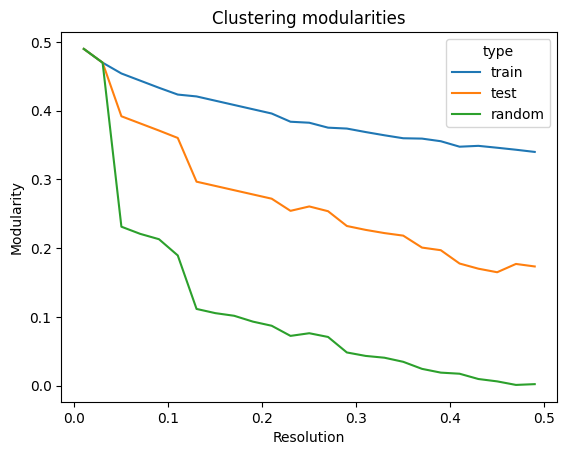

In [35]:
sns.lineplot(data=mod_df, x="resolution", y="score", hue="type")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Modularity")
plt.show()

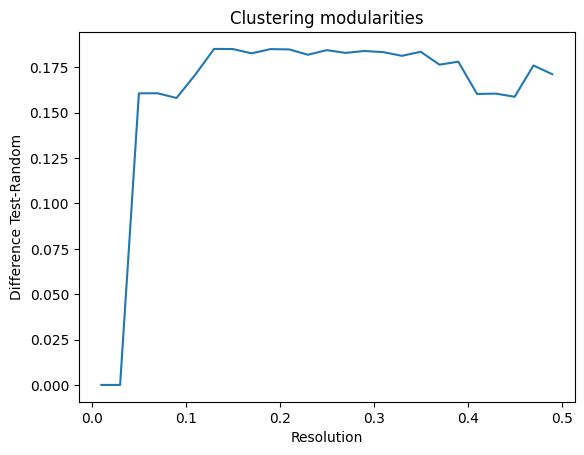

In [36]:
sns.lineplot(data=mod_df_wide, x="resolution", y="diff_rand_test")
plt.title("Clustering modularities")
plt.xlabel("Resolution")
plt.ylabel("Difference Test-Random")
plt.show()

## Cluster analysis

In [31]:
res_opt = 0.13

In [51]:
sc.tl.leiden(dat, resolution=res_opt, key_added="leiden_opt")

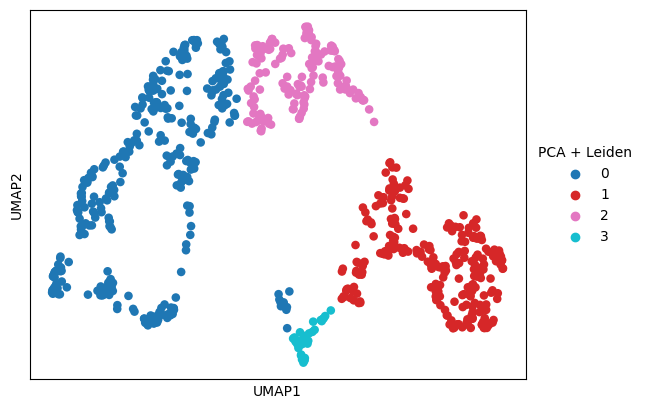

In [49]:
umap_plot_pca_clusters = sc.pl.umap(dat, color="leiden_opt", palette="tab10", return_fig=True)
ax = umap_plot_pca_clusters.axes[0]
ax.legend_.set_title("PCA + Leiden")
ax.set_title(None)
plt.savefig("./pca_umap_phclust_pca_cluster.svg")
plt.show()

In [39]:
dat.obs.keys()

Index(['n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'outlier', 'n_genes', 'total_counts_norm',
       'total_counts_scale', 'leiden_opt'],
      dtype='object')

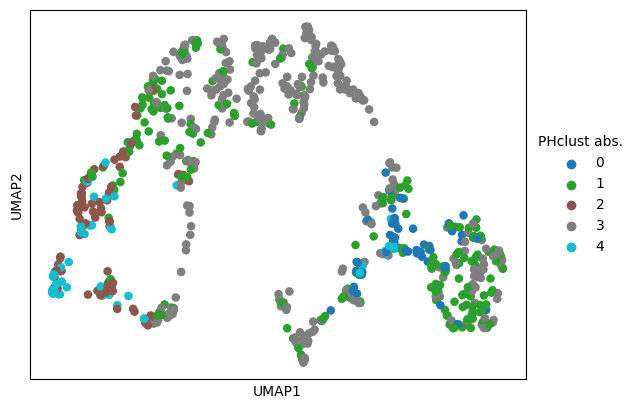

In [47]:
umap_plot_phclust_abs_clusters = sc.pl.umap(dat, color="phclust_abs_k5", palette="tab10", return_fig=True)
ax = umap_plot_phclust_abs_clusters.axes[0]
ax.legend_.set_title("PHclust abs.")
ax.set_title(None)
plt.savefig("./pca_umap_phclust_abs_k5.svg")
plt.show()

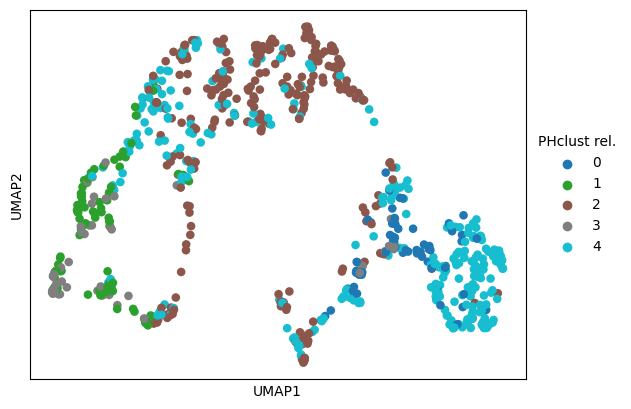

In [48]:
umap_plot_phclust_abs_clusters = sc.pl.umap(dat, color="phclust_rel_k5", palette="tab10", return_fig=True)
ax = umap_plot_phclust_abs_clusters.axes[0]
ax.legend_.set_title("PHclust rel.")
ax.set_title(None)
plt.savefig("./pca_umap_phclust_rel_k5.svg")
plt.show()

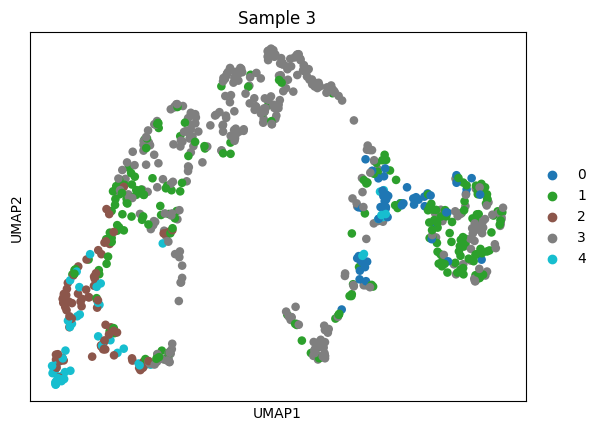

In [69]:
sc.pl.umap(dat, color="phclust_abs_k5", palette="tab10", title="Sample 3")
plt.show()

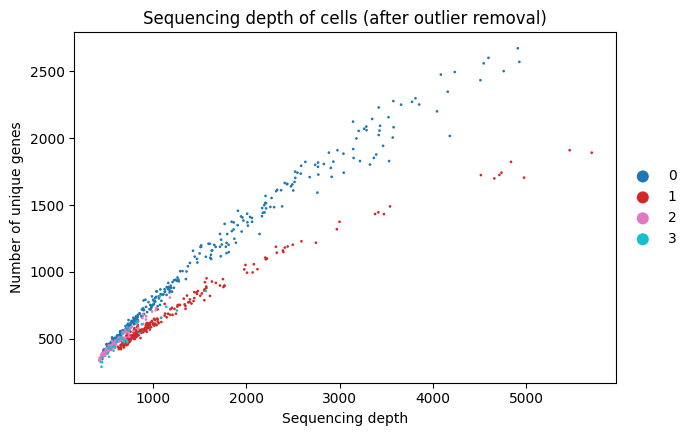

In [52]:
sc.pl.scatter(dat, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="leiden_opt")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

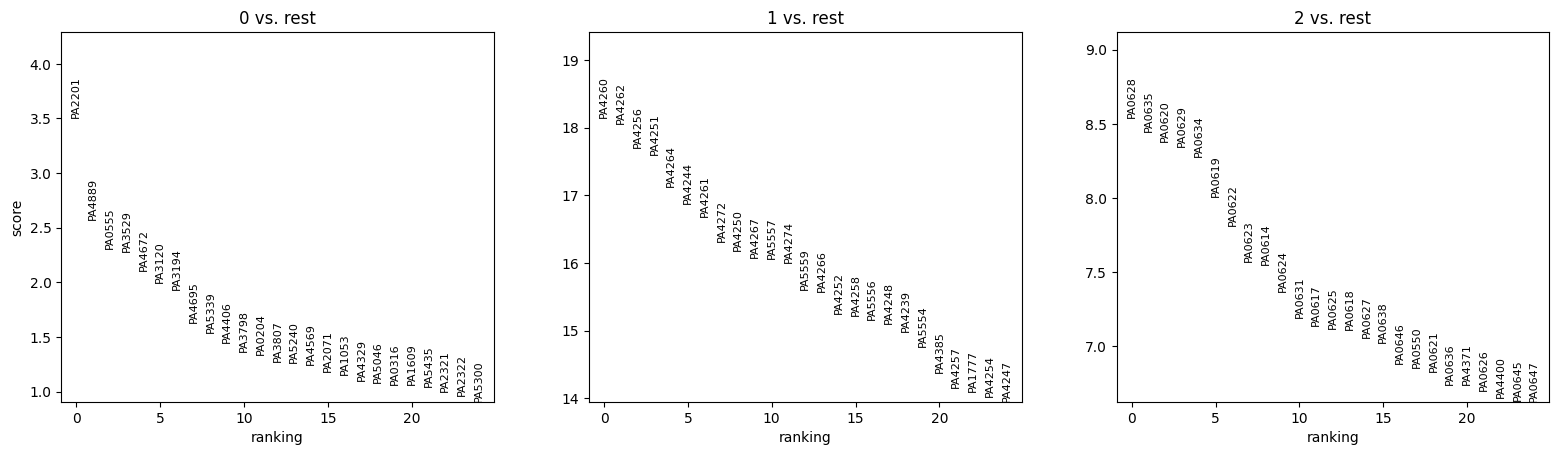

In [46]:
sc.tl.rank_genes_groups(dat, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(dat, n_genes=25, sharey=False)

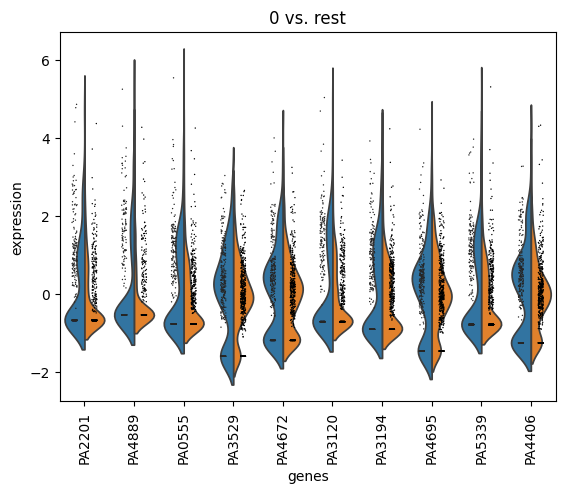

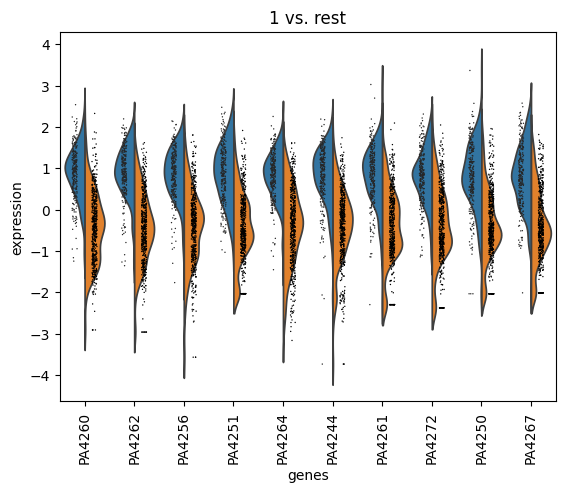

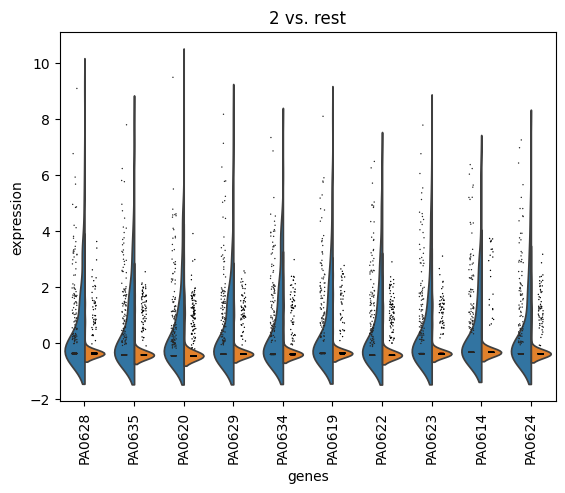

In [47]:
nclust = len(np.unique(dat.obs["leiden_opt"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(dat, groups=str(i), n_genes=10)

## Leiden Clustering vs. Poisson hurdle

In [55]:
from scipy.optimize import linear_sum_assignment

def sort_confusion_matrix(matrix):
    """
    Sort a non-quadratic confusion matrix along its diagonal.

    Parameters:
    matrix (pd.DataFrame): Confusion matrix generated by pd.crosstab

    Returns:
    pd.DataFrame: Sorted confusion matrix
    """
    
    matrix_np = matrix.to_numpy()
    row_ind, col_ind = linear_sum_assignment(matrix_np, maximize=True)
    sorted_matrix = matrix_np[row_ind, :][:, col_ind]
    sorted_matrix_df = pd.DataFrame(sorted_matrix, 
                                    index=matrix.index[row_ind], 
                                    columns=matrix.columns[col_ind])
    
    return sorted_matrix_df

In [53]:
dat.obs["phclust_abs_k5"] = phclust_abs["cluster"]
dat.obs["phclust_rel_k5"] = phclust_rel["cluster"]

In [58]:
cm_pca_phclust_abs

Poisson-Hurdle (abs)   2    1    3   0
PCA_Leiden                            
0                     87   88  116   0
1                      0  111   82  51
2                      0   12  144   0
3                      0    8   28   1

In [57]:
ct_pca_phclust_abs = pd.crosstab(dat.obs["leiden_opt"], dat.obs["phclust_abs_k5"], 
                                 rownames=['PCA_Leiden'], colnames=['Poisson-Hurdle (abs)'])
cm_pca_phclust_abs = sort_confusion_matrix(ct_pca_phclust_abs)
conf_matrix_pca_vs_nmd_norm = pd.concat([cm_pca_phclust_abs, ct_pca_phclust_abs["4"]], axis=1)
conf_matrix_pca_vs_nmd_norm

2    1    3   0   4
PCA_Leiden                      
0           87   88  116   0  45
1            0  111   82  51  12
2            0   12  144   0   0
3            0    8   28   1   0

In [61]:
print(conf_matrix_pca_vs_nmd_norm.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &   2 &    1 &    3 &   0 &   4 \\
PCA\_Leiden &     &      &      &     &     \\
\midrule
0          &  87 &   88 &  116 &   0 &  45 \\
1          &   0 &  111 &   82 &  51 &  12 \\
2          &   0 &   12 &  144 &   0 &   0 \\
3          &   0 &    8 &   28 &   1 &   0 \\
\bottomrule
\end{tabular}



In [72]:
pd.crosstab(dat.obs["phclust_rel_k5"], dat.obs["phclust_abs_k5"], rownames=['Poisson-Hurdle (rel)'], colnames=['Poisson-Hurdle (abs)'])

Poisson-Hurdle (abs)   0    1   2    3   4
Poisson-Hurdle (rel)                      
0                     51    9   0    0   0
1                      0    3  84    0   0
2                      0    0   0  288   0
3                      1    0   3    0  57
4                      0  207   0   82   0

Beachte: rank genes groups berechnet wilcoxon test auf normalized data aber Clustering ist auf raw counts

In [51]:
sc.tl.rank_genes_groups(dat, "phclust_abs_k5")

In [57]:
top_genes_3 = [x[3] for x in dat.uns["rank_genes_groups"]["names"]]
print(top_genes_3[:25])

['PA2853', 'PA0641', 'PA0621', 'PA4848', 'PA4259', 'PA0001', 'PA4241', 'PA3372', 'PA0617', 'PA5046', 'PA3946', 'PA1801', 'PA1439', 'PA1053', 'PA4662', 'PA4752', 'PA4268', 'PA0437', 'PA3115', 'PA2323', 'PA0316', 'PA0417', 'PA4264', 'PA5129', 'PA0555']


 plotte normalisierte dat.X

In [ ]:
sc.pl.heatmap(dat, layer="counts")

In [67]:
dat.X

array([[-0.79157024, -0.62632685, -0.92808681, ..., -0.75180101,
        -0.33151332, -0.54070608],
       [-0.79157024, -0.62632685,  0.43683659, ...,  0.8528083 ,
         2.12694888, -0.54070608],
       [ 0.54060741, -0.62632685,  0.2494029 , ..., -0.75180101,
         1.46645026, -0.54070608],
       ...,
       [ 0.05528771,  0.94191113, -0.6706983 , ...,  0.13015118,
         0.55633858, -0.18616415],
       [ 1.14817444, -0.62632685, -0.92808681, ...,  1.26286943,
        -0.73460129, -0.54070608],
       [-0.79157024,  0.06662249, -0.40298378, ..., -0.13156683,
        -0.03974437, -0.54070608]])

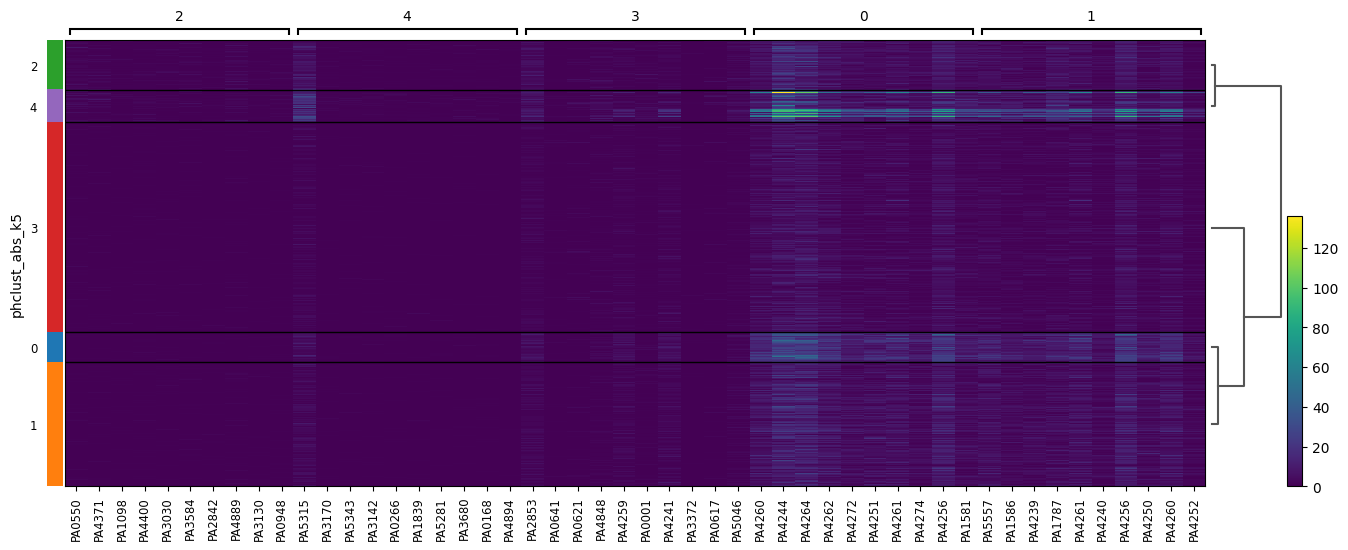

In [68]:
sc.pl.rank_genes_groups_heatmap(dat, n_genes=10, show_gene_labels=True, layer="counts")

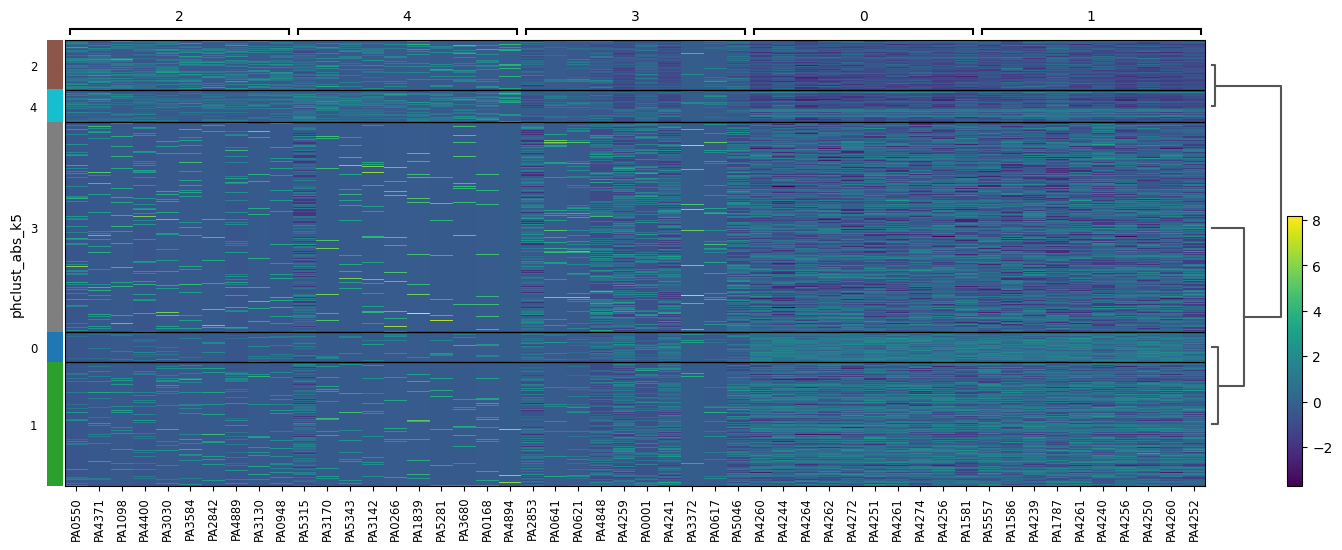

In [70]:
sc.pl.rank_genes_groups_heatmap(dat, n_genes=10, show_gene_labels=True)

In [70]:
import matplotlib.transforms as mtransforms

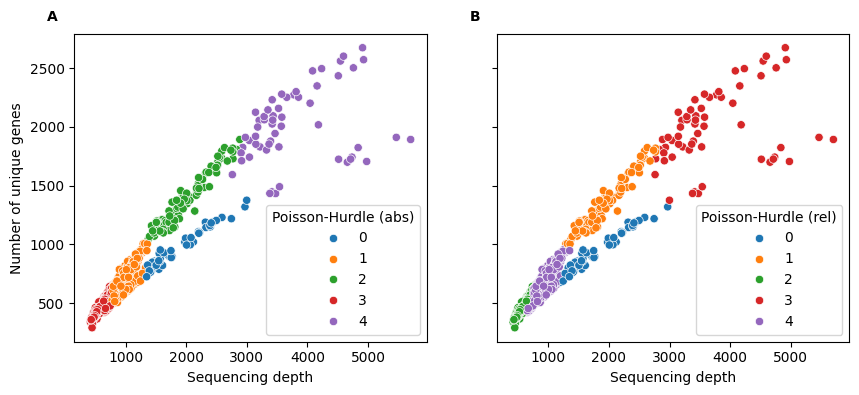

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 4], sharex=True, sharey=True)
sns.scatterplot(x=dat.obs["total_counts"], 
                y=dat.obs["n_genes_by_counts"], 
                hue=dat.obs["phclust_abs_k5"],palette="tab10", ax=ax1)
ax1.set_ylabel("Number of unique genes")
ax1.set_xlabel("Sequencing depth")
ax1.legend_.set_title('Poisson-Hurdle (abs)')
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, "A", transform=ax1.transAxes + trans,
         fontsize='medium', va='bottom', fontweight="bold")

sns.scatterplot(x=dat.obs["total_counts"], 
                y=dat.obs["n_genes_by_counts"], 
                hue=dat.obs["phclust_rel_k5"], palette="tab10", ax=ax2)
ax2.set_ylabel(None)
ax2.set_xlabel("Sequencing depth")
ax2.legend_.set_title('Poisson-Hurdle (rel)')
ax2.text(0.0, 1.0, "B", transform=ax2.transAxes + trans,
         fontsize='medium', va='bottom', fontweight="bold")
plt.savefig("./seq_depth_vs_unique_genes_huePHclust_abs.svg", format="svg")
plt.show()

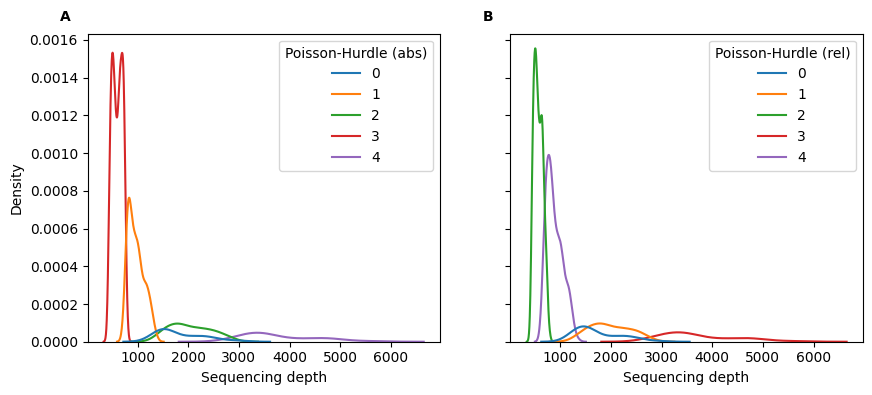

In [77]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 4], sharex=True, sharey=True)
sns.kdeplot(x=dat.obs["total_counts"], 
                hue=dat.obs["phclust_abs_k5"],palette="tab10", ax=ax1)
ax1.set_xlabel("Sequencing depth")
ax1.legend_.set_title('Poisson-Hurdle (abs)')
trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
ax1.text(0.0, 1.0, "A", transform=ax1.transAxes + trans,
         fontsize='medium', va='bottom', fontweight="bold")

sns.kdeplot(x=dat.obs["total_counts"], 
             hue=dat.obs["phclust_rel_k5"], palette="tab10", ax=ax2)
ax2.set_ylabel(None)
ax2.set_xlabel("Sequencing depth")
ax2.legend_.set_title('Poisson-Hurdle (rel)')
ax2.text(0.0, 1.0, "B", transform=ax2.transAxes + trans,
         fontsize='medium', va='bottom', fontweight="bold")
plt.savefig("./seq_depth_histplot_huePHclust_abs_rel.svg", format="svg")
plt.show()

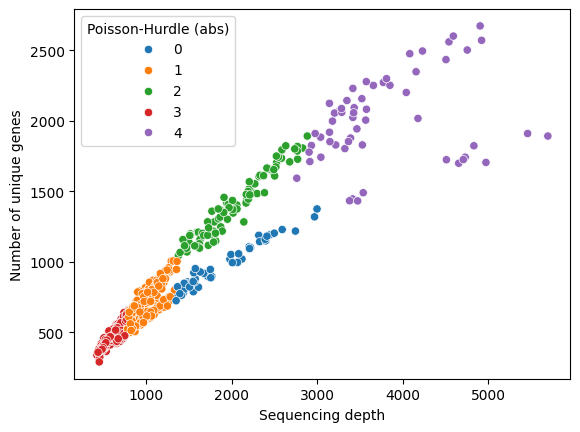

In [69]:
fig, (ax1, ax2) = plt.subplots()
sns.scatterplot(x=dat.obs["total_counts"], 
                y=dat.obs["n_genes_by_counts"], 
                hue=dat.obs["phclust_abs_k5"], ax=ax, palette="tab10")
ax.set_ylabel("Number of unique genes")
ax.set_xlabel("Sequencing depth")
ax.legend_.set_title('Poisson-Hurdle (abs)')

plt.savefig("./seq_depth_vs_unique_genes_huePHclust_abs.svg")
plt.show()

In [65]:
fig = sc.pl.scatter(dat, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="phclust_abs_k5", 
                    return_fig=True)
ax1 = fig.axes[0]
ax1.set_xlabel("Sequencing depth")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
ax.legend_.set_title("Poisson-Hurdle (abs)")
plt.show()

TypeError: scatter() got an unexpected keyword argument 'return_fig'

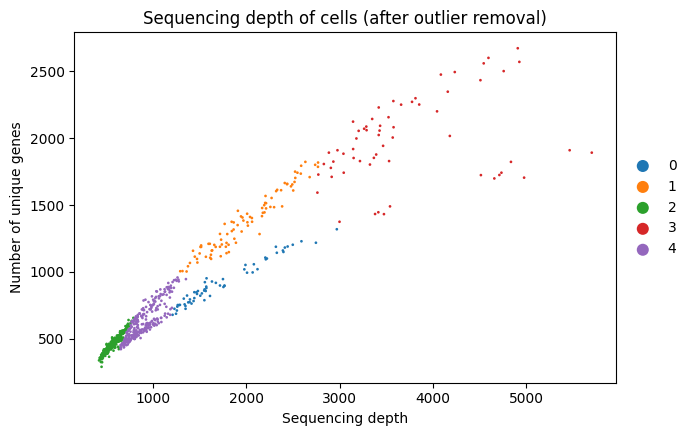

In [73]:
sc.pl.scatter(dat, x='total_counts', y='n_genes_by_counts', show=False, size=15, color="phclust_rel_k5")
plt.title("Sequencing depth of cells (after outlier removal)")
plt.xlabel("Sequencing depth")
plt.ylabel("Number of unique genes")
plt.show()

In [78]:
# wieviele gene haben adj pval smaller xx
# dann p-val distribution der einzelnen gene, wieviele sind differentially expressed
dat.uns["rank_genes_groups"]["pvals_adj"]

rec.array([(2.29623143e-29, 3.70807127e-06, 3.23879660e-05, 3.17054745e-02, 7.58921381e-06),
           (1.02532473e-26, 1.02544529e-04, 3.83878491e-05, 4.27154498e-02, 8.10721824e-05),
           (2.11350682e-26, 1.02544529e-04, 5.89388642e-05, 5.56909121e-02, 1.69449105e-04),
           ...,
           (6.57674046e-13, 4.46770551e-04, 1.63132242e-26, 4.77515383e-06, 7.58921381e-06),
           (9.63795204e-23, 3.70155198e-04, 4.24716662e-29, 2.87620591e-06, 7.03792832e-06),
           (1.11477736e-29, 1.02544529e-04, 5.11808877e-31, 1.30660945e-08, 1.90648218e-10)],
          dtype=[('0', '<f8'), ('1', '<f8'), ('2', '<f8'), ('3', '<f8'), ('4', '<f8')])

In [81]:
dat.uns["rank_genes_groups"]["names"]

rec.array([('PA4260', 'PA5557', 'PA0550', 'PA2853', 'PA5315'),
           ('PA4244', 'PA1586', 'PA4371', 'PA0641', 'PA3170'),
           ('PA4264', 'PA4239', 'PA1098', 'PA0621', 'PA5343'), ...,
           ('PA0920', 'PA3846', 'PA4260', 'PA2742', 'PA4259'),
           ('PA2201', 'PA2088', 'PA4258', 'PA2633', 'PA4433'),
           ('PA0204', 'PA2269', 'PA4252', 'PA1787', 'PA4268')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O')])

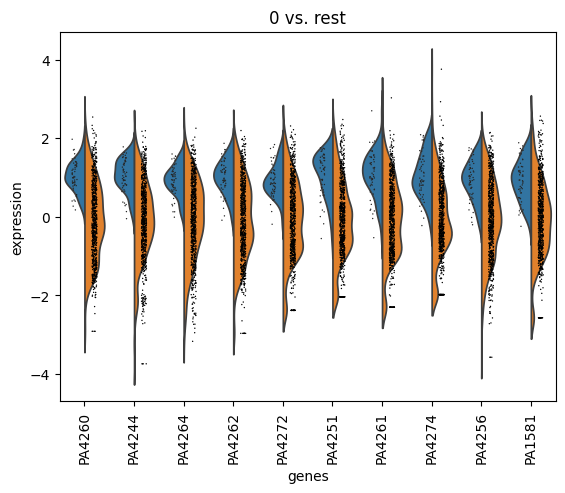

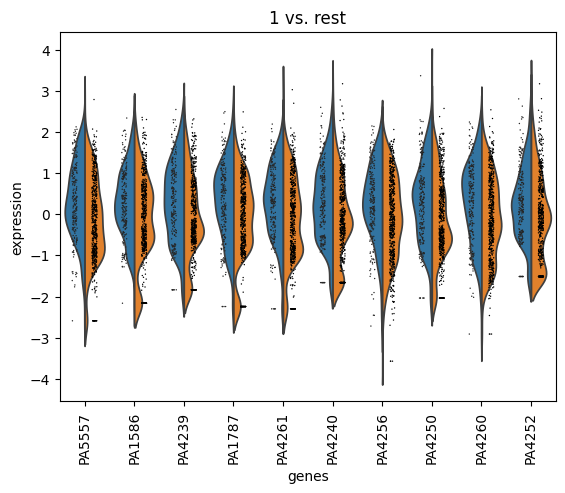

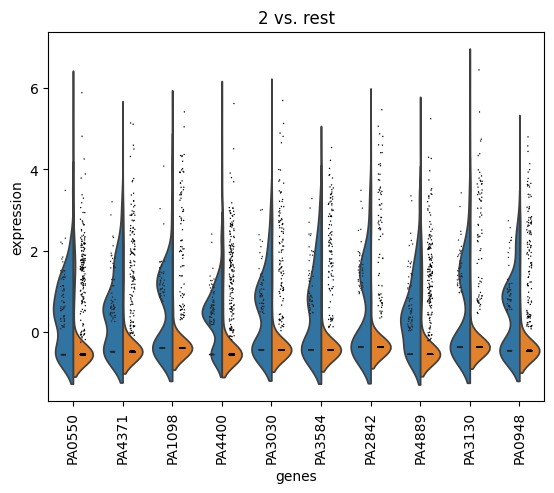

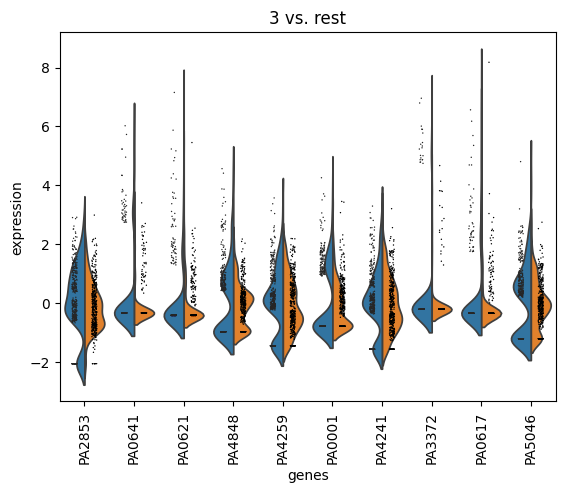

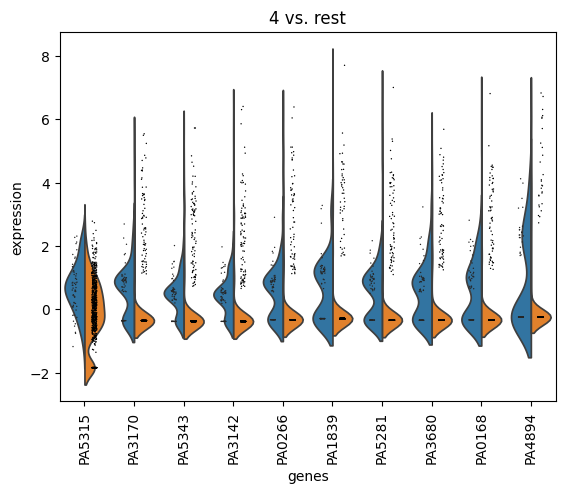

In [74]:
nclust = len(np.unique(dat.obs["phclust_abs_k5"]))

for i in range(nclust):
    sc.pl.rank_genes_groups_violin(dat, groups=str(i), n_genes=10)